In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
import os 
import cmasher as cmr
import sys
sys.path.append('Lib/')
from Zams_KDE_files import CMDFormatter
from astropy.io import ascii
from matplotlib import rcParams
from scipy import stats
directory = os.getenv("DATADIR")

plt.style.use(directory+'bl.mplstyle')
rcParams["mathtext.fontset"] = 'cm'
dir = directory + '4_MagellanicClouds/Extinction/'

#######################
# Set Plot Parameters #
#######################
labelsize = 14
ticksize = 12
textsize = 11
legendsize = 11

background_c = '#F6FBFE' 
background_a = 1 

smc = CMDFormatter('smc')
lmc = CMDFormatter('lmc')

mesa_df = lmc.Generate_MS_Table()

dc = ['#A5d8ff','#8FE388','#6290c3','']

color_space = ['uvm2_v','uvw1_b','u_v']

alphas = [1,1,1,1]
ns = [200,50,50,30]
zorders = [7,6,5,4]

c1 = '#fe439b' 
c4 = '#72788D'
c3 = '#7A89C2'
c2 = '#E3D7FF'

ranks = ['VB-E', 'VB-G', 'B-E', 'B-G']
rank_colors = [c1,c2,c3,c4]


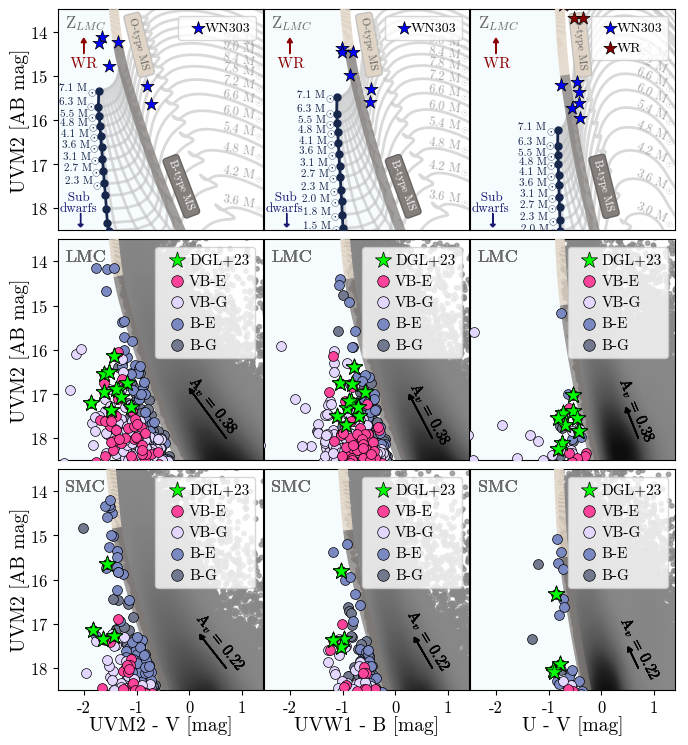

In [4]:
f, axes = plt.subplots(3,3,figsize=(7.13,9.13 - 1.5))

counter_top, counter_bottom = 0, 0
for galaxy, galaxy_label, axs in zip([lmc,lmc,smc],["TOP","LMC","SMC"],[axes[0,:],axes[1,:],axes[2,:]]):
    for ax,colorspace,i in zip(axs.flatten(),color_space,range(len(color_space))):
        uv, opt = colorspace.split('_')

        # Plot ZAMS
        lc,zams_x,zams_y = galaxy.zams_threshold_plot(ax, uv, opt)
        lc.set_linewidth(7)
        ax.fill_betweenx(zams_y,np.repeat(-3,len(zams_y)),zams_x,alpha=background_a ,color=background_c,zorder=0)

        # Formatting
        xlabels  = ['UVM2 - V [mag]','UVW1 - B [mag]','U - V [mag]']
        ylabels  = ['UVM2 [AB mag]','UVW1 [AB mag]','U [AB mag]']
        ax.set_xlabel(xlabels[i],fontsize=labelsize)
        ax.set_ylabel(ylabels[i],fontsize=labelsize)
        ax.tick_params(axis='both', labelsize=ticksize)
        ax.set_ylim(18.5,13.5)
        ax.set_xlim(-2.49,1.4)
        ax.set_xticks([-2,-1,0,1])
        ax.set_xticklabels([-2,-1,0,1])

        # Bottom two rows
        if galaxy_label != "TOP":

            # Plot kdes
            k_df = galaxy.kdes[colorspace]
            x,y,z = k_df[f'{colorspace}_x'],k_df[f'{colorspace}_y'],k_df[f'{colorspace}_z']
            if galaxy_label == "LMC":
                ax.scatter(x - 0.05,y,c=z,s=10,zorder=0,edgecolor=None,cmap=galaxy.kde_cmap,label="",alpha=0.7)
            else:
                ax.scatter(x,y,c=z,s=10,zorder=0,edgecolor=None,cmap=galaxy.kde_cmap,label="",alpha=0.7)


            # Plot Stars by rank 
            for rank,rank_color,alpha,z in zip(ranks,rank_colors,alphas,zorders):
                uv, opt = colorspace.split('_')
                df = galaxy.candidates
                # Plot confirmed candidates 
                obs_stars = [f'Star_{i}' for i in range(1,17)]
                confirmed = df[df['discovery_name'].isin(obs_stars)]
                x = confirmed[f'{uv}'] - confirmed[f'{opt}']
                y = confirmed[f'{uv}']
                ax.scatter(x,y,s=150,edgecolor='k',facecolor='lime',linewidth=0.5,marker="*",alpha=1,zorder=100,label='DGL+23')

                edge_color='k'
                uv, opt = colorspace.split('_')
                df = galaxy.candidates
                rf = df[(df[f'{uv} - {opt}'] == 'blue') & (df['cut'] == rank)]
                x = rf[f'{uv}'] - rf[f'{opt}']
                y = rf[f'{uv}']
                ax.scatter(x,y,s=50,edgecolor=edge_color,facecolor=rank_color,linewidth=0.5,marker="o",alpha=alpha,zorder=z)
                # For legend
                ax.scatter(0,0,s=70,edgecolor=edge_color,facecolor=rank_color,linewidth=0.5,zorder=10,label=rank,marker="o",alpha=alpha)

                # Av Arrow 
                offsets_r = [6, 4, 4, 5, 5, 5]
                offsets_x = [-18, -12, -14, -17, -16, -14]
                offsets_y = [-13, -18, -11, -12, -11, -13]
                galaxy.plot_arrow(ax,x=0.7,y=18,
                                blue_band=uv,red_band=opt,
                                offset_x = offsets_x[counter_bottom], offset_y = offsets_y[counter_bottom], offset_r = offsets_r[counter_bottom], 
                                fontsize=textsize)
                ax.text(-2.35,14,galaxy_label,fontsize = legendsize+2,weight='bold',color='dimgray')
            
            # Legend
            handles, labels = axes[1,0].get_legend_handles_labels()
            # Only plot Drout+23 once
            handles = [[handles[0]] + [handles[1]] + [handles[3]] + [handles[5]] + [handles[7]]]
            labels = [[labels[0]] + [labels[1]] + [labels[3]] + [labels[5] ]+ [labels[7]]]
            # Combine handles
            ax.legend(handles[0],labels[0],fontsize=legendsize,loc='upper right',handletextpad=-0.2)
            counter_bottom += 1
        
        # Top row
        else:
            # Evolutionary Models - MS 
            vals = [float(f[:3]  + '.' + f[3]) for f in lmc.mist_fnames]
            rotation = [-10,-8,-25]
            text_offset = [0,0.0,0.15]
            min_text = [3.1,3.1,0]
            max_text = [9.7,9.3,8.3]
            for mdf,val in zip(mesa_df,vals):
                m_x = mdf[uv.upper()] - mdf[opt.upper()]
                m_y = mdf[uv.upper()]
                ax.plot(m_x,m_y,color='silver',linewidth=2,alpha=0.6,zorder=0)
                # What is y when uv - opt = 1
                diff = np.abs(m_x - 1)
                mlabel_y = m_y[diff.argmin()]
                if val < max_text[counter_top] and val > min_text[counter_top]:
                    ax.text(.6,mlabel_y+text_offset[counter_top],f'{val} M'+r'$_\odot$',fontsize=textsize-2,color='darkgrey',rotation=rotation[counter_top]) 
                

            # LMC label on top panel
            ax.text(-2.35,13.9,r"Z$_{LMC}$",fontsize = legendsize+1,weight='bold',color='dimgray') 
            

            # Zams Box
            Ox = [-0.95,-0.5,-0.4]
            Or = [-76,-80,-84]
            Bx = [-0.15,0.15,0.05]
            Br = [-69,-70,-76]

            galaxy.ostar_box(ax,x=Ox[counter_top] ,rotation=Or[counter_top],fontsize=textsize-3)
            galaxy.bstar_box(ax,x=Bx[counter_top],rotation=Br[counter_top],fontsize=textsize-3)

            # Evolutionary Models - Stripped stars
            evol = lmc.composites[lmc.composites.frac_MS==0.0]
            evol_x = evol[uv] - evol[opt]
            evol_y = evol[uv]
            ax.plot(evol_x,evol_y,'-o',linewidth=2.,markersize=5,color='#17274C',zorder=10)
            M = evol.M_strip.unique()
            m_start = [2.2,1.5,1.9]
            for m,ex,ey in zip(M,evol_x, evol_y):   
                if m > m_start[counter_top]:
                    ev_txt_x = ex - 0.75
                    ev_txt_y = ey
                    if np.round(m,1) == 6.3:
                        ax.text(ev_txt_x,ev_txt_y-0.05,f'{np.round(m,1)} M',fontsize=textsize-3,color='#17274C',rotation=0)
                        ax.text(ev_txt_x+0.52,ev_txt_y+0.11-0.05,r'$\odot$',fontsize=textsize-3,color='#17274C',rotation=0)
                    else:
                        ax.text(ev_txt_x,ev_txt_y,f'{np.round(m,1)} M',fontsize=textsize-3,color='#17274C',rotation=0,clip_on=True)
                        ax.text(ev_txt_x+0.52,ev_txt_y+0.11,r'$\odot$',fontsize=textsize-3,color='#17274C',rotation=0,clip_on=True)


            # Composite Models
            composites = lmc.composites[lmc.composites.frac_MS==0.2]
  
            web_m = [np.round(i,1) for i in np.arange(1.2,9.0,0.6)]
            composites_web = composites[composites.M_MS.isin(web_m)].copy().reset_index(drop=True)
            distances = lmc.DistanceFromZamsForModels(composites_web,uv,opt)
            composites_web = composites_web[distances < 0]

            # Wolf Rayet Stars 
            wr_color = 'darkred'

            wn = lmc.wr[lmc.wr.type=='wn303']
            wn_x = wn[uv.upper()] - wn[opt.upper()]
            wn_y = wn[uv.upper()]
            ax.scatter(wn_x,wn_y,s=100,edgecolor='black',facecolor='blue',linewidth=0.5,zorder=10,marker="*",label='WN303')
            wr = lmc.wr[lmc.wr.type=='wr']
            wr_x = wr[uv.upper()] - wr[opt.upper()]
            wr_y = wr[uv.upper()]
            # Plot WR 
            if counter_top == 2:
                ax.scatter(wr_x,wr_y,s=100,edgecolor='black',facecolor=wr_color,linewidth=0.5,zorder=10,marker="*",label='WR')
            # Plot arrow pointing up
            # x, y, dx, dy 
            wr_x = -1.8
            wr_y = 14.7 
            ax.arrow(wr_x-0.2,wr_y-0.2,0,-0.25,head_width=0.1, head_length=0.1, fc=wr_color, ec=wr_color,zorder=10)
            ax.annotate(f'   WR', xy=(wr_x, 0.5/2 + wr_y), xytext=(-28, 7), textcoords='offset points',color=wr_color,fontsize=textsize,
                        family="serif",font="Times New Roman",weight="bold",va='center')
            ax.legend(fontsize=ticksize-2,loc='upper right',handletextpad=-0.5)

            # Subdwarfs 
            # x, y, dx, dy 
            sd_x = -2.46
            sd_y = 17.76
            sd_color = 'midnightblue'
            ax.text(sd_x,sd_y,'  Sub',fontsize=textsize-1.5,color=sd_color,va='center')
            ax.text(sd_x,sd_y+0.25,'dwarfs',fontsize=textsize-1.5,color=sd_color,va='center')
            ax.arrow(sd_x+0.4,sd_y+0.35,0,0.25,head_width=0.1, head_length=0.06, fc=sd_color, ec=sd_color,zorder=10)
            

            # Vertical lines
            #[2.21, 2.44, 2.7 , 2.99, 3.3 , 3.65, 4.04, 4.46, 4.93, 5.45, 6.03, 6.66, 7.37]
            for M in composites_web.M_MS.unique():
                comp_row = composites_web[composites_web.M_MS == M]
                comp_x = comp_row[uv] - comp_row[opt]
                comp_y = comp_row[uv]
                ax.plot(comp_x, comp_y,'-',color='silver',linewidth=2,alpha=0.6,zorder=1)
            
            for M in composites_web.Minit_strip.unique():
                evol_row = evol[evol.Minit_strip == M]
                comp_row = composites_web[composites_web.Minit_strip == M]
                evol_x = evol_row[uv] - evol_row[opt]
                evol_y = evol_row[uv]
                comp_x = comp_row[uv] - comp_row[opt]
                comp_y = comp_row[uv]
                model_x = np.append(evol_x,comp_x)
                model_y = np.append(evol_y,comp_y)
                ax.plot(model_x, model_y,'-',color='silver',linewidth=2,alpha=0.6)


            counter_top += 1

# Turn off ylabels if not in first column
for i in range(3):
    for ax in axes[i,1:]:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.set_yticks([])
# Turn off xlabels if in first two rows
for i in range(2):
    for ax in axes[i,:]:
        ax.set_xlabel('')
        ax.set_xticklabels([])
        ax.set_xticks([])
        
plt.tight_layout(w_pad=-1.2,h_pad=0.5)
plt.savefig(f'CMD.png',dpi=300,bbox_inches='tight');

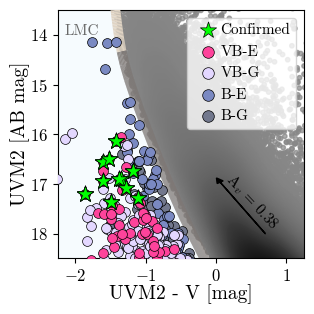

In [5]:
# Single CMD
f, ax = plt.subplots(1,1,figsize=(3.3,3.3))

colorspace = 'uvm2_v'
uv = 'uvm2'
opt = 'v'
galaxy = lmc
galaxy_label = "LMC"
counter_bottom =0

# Plot ZAMS
lc,zams_x,zams_y = galaxy.zams_threshold_plot(ax, uv, opt)
lc.set_linewidth(7)
ax.fill_betweenx(zams_y,np.repeat(-3,len(zams_y)),zams_x,alpha=background_a ,color=background_c,zorder=0)

# Formatting
xlabels  = ['UVM2 - V [mag]','UVW1 - B [mag]','U - V [mag]']
ylabels  = ['UVM2 [AB mag]','UVW1 [AB mag]','U [AB mag]']
ax.set_xlabel(xlabels[0],fontsize=labelsize)
ax.set_ylabel(ylabels[0],fontsize=labelsize)
ax.tick_params(axis='both', labelsize=ticksize)
ax.set_ylim(18.5,13.5)
ax.set_xlim(-2.25,1.25)

# Plot kdes
k_df = galaxy.kdes[colorspace]
x,y,z = k_df[f'{colorspace}_x'],k_df[f'{colorspace}_y'],k_df[f'{colorspace}_z']
if galaxy_label == "LMC":
    ax.scatter(x - 0.05,y,c=z,s=10,zorder=0,edgecolor=None,cmap=galaxy.kde_cmap,label="",alpha=0.7)
else:
    ax.scatter(x,y,c=z,s=10,zorder=0,edgecolor=None,cmap=galaxy.kde_cmap,label="",alpha=0.7)

# Plot Stars by rank 
for rank,rank_color,alpha,z in zip(ranks,rank_colors,alphas,zorders):
    edge_color='k'
    uv, opt = colorspace.split('_')
    df = galaxy.candidates
    rf = df[(df[f'{uv} - {opt}'] == 'blue') & (df['cut'] == rank)]
    x = rf[f'{uv}'] - rf[f'{opt}']
    y = rf[f'{uv}']
    ax.scatter(x,y,s=50,edgecolor=edge_color,facecolor=rank_color,linewidth=0.5,marker="o",alpha=alpha,zorder=z)
    # For legend
    ax.scatter(0,0,s=70,edgecolor=edge_color,facecolor=rank_color,linewidth=0.5,zorder=10,label=rank,marker="o",alpha=alpha)

    # Plot confirmed candidates 
    obs_stars = [f'Star_{i}' for i in range(1,17)]
    confirmed = df[df['discovery_name'].isin(obs_stars)]
    x = confirmed[f'{uv}'] - confirmed[f'{opt}']
    y = confirmed[f'{uv}']
    ax.scatter(x,y,s=150,edgecolor='k',facecolor='lime',linewidth=0.5,marker="*",alpha=1,zorder=100,label='Confirmed')

# Av Arrow
offsets_r = [11, 11]
offsets_x = [-15, -15]
offsets_y = [-15, -15]
galaxy.plot_arrow(ax,x=0.7,y=18,
                blue_band=uv,red_band=opt,
                offset_x = offsets_x[counter_bottom], offset_y = offsets_y[counter_bottom], offset_r = offsets_r[counter_bottom], 
                fontsize=textsize)
ax.text(-2.15,14,galaxy_label,fontsize = textsize,weight='bold',color='dimgray')
    
# Legend
handles, labels = ax.get_legend_handles_labels()
# Only plot Drout+23 once
handles = [[handles[1]] + [handles[0]] + [handles[2]] + [handles[4]] + [handles[6]]]
labels = [[labels[1]] + [labels[0]] + [labels[2]] + [labels[4] ]+ [labels[6]]]
# Combine handles
ax.legend(handles[0],labels[0],fontsize=legendsize,loc='upper right',handletextpad=-0.2)

    
plt.tight_layout()
plt.savefig(f'CMD_Single_Single.pdf',dpi=300,bbox_inches='tight');